# Example notebook to showcase the usage of the Poisson VAE model

We showcase the model on a 10X ATAC sample dataset. The data can be downloaded from [here](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-atac-v2-chromium-controller-2-standard).

## Load packages

In [1]:
%load_ext autoreload
%autoreload 2
import os
import scanpy as sc
import anndata as ad
import poisson_atac as patac

Global seed set to 0


In [2]:
data_path = 'data'

## Load the data

In [3]:
adata = sc.read_10x_h5(os.path.join(data_path, '10X/10k_Human_PBMCs_ATAC_v2_Chromium_Controller', '10k_pbmc_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.h5'), gex_only=False)

## Plot count distributions

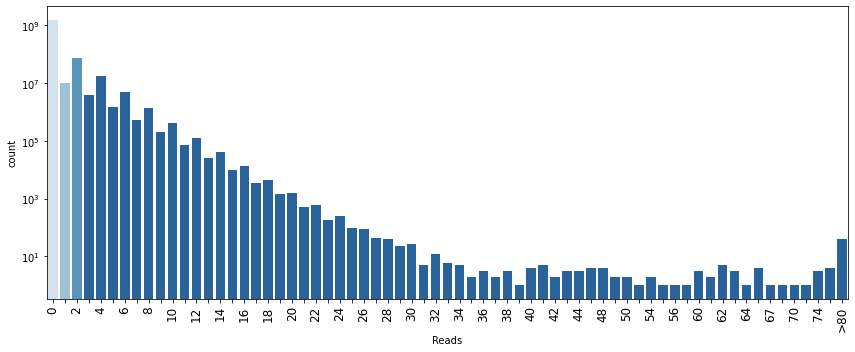

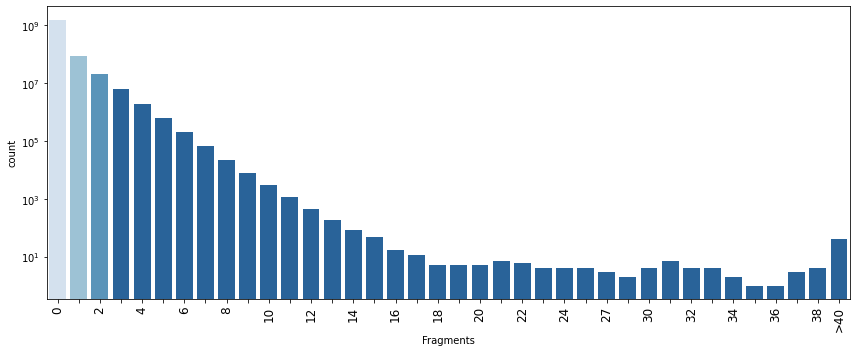

In [4]:
patac.pl.count_distribution(adata, figsize=(12, 5), limit=80)

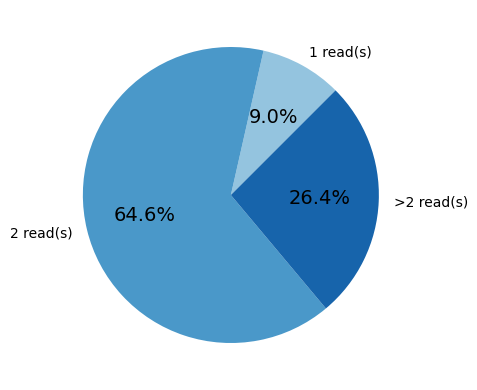

In [5]:
patac.pl.proportions(adata, lower_limit=1, upper_limit=2)

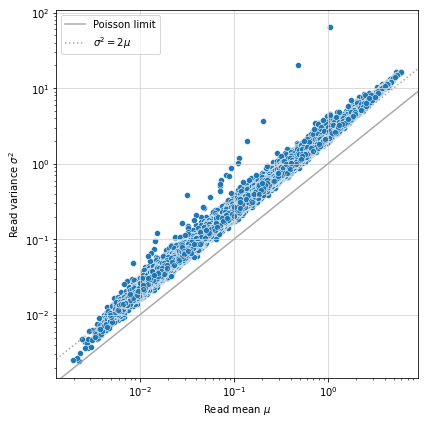

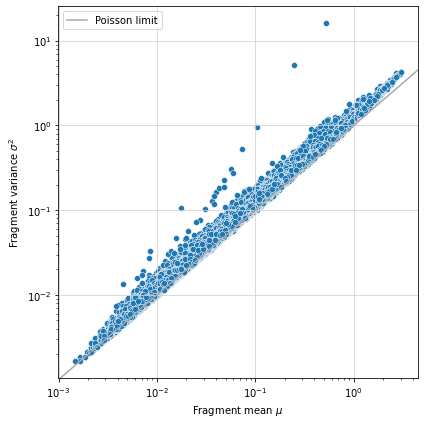

In [7]:
patac.pl.mean_variance(adata, figsize=(6,6))

## Convert to fragment counts

In [4]:
adata = patac.data.reads_to_fragments(adata, layer=None, key_added='counts', copy=True)

## Setup PoissonVAE model

The model is based on the scvi models. They have a great documentation at https://scvi-tools.org/. Here you will also find more information on the parameters you can use in the setup and training of the model.

In [5]:
patac.model.PoissonVI.setup_anndata(adata, layer="counts") # if you have batches use batch='obs_key'

In [6]:
model = patac.model.PoissonVI(adata)

In [7]:
model.module

PoissonVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=165434, out_features=406, bias=True)
          (1): None
          (2): LayerNorm((406,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=406, out_features=406, bias=True)
          (1): None
          (2): LayerNorm((406,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=406, out_features=20, bias=True)
    (var_encoder): Linear(in_features=406, out_features=20, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=165434, out_feature

## Train PoissonVAE model

In [8]:
model.train(train_size=0.9, 
            validation_size=0.1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 101/500:  20%|███            | 101/500 [11:07<43:55,  6.60s/it, loss=3.48e+04, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 34696.414. Signaling Trainer to stop.


## Compute and plot embedding

In [10]:
# Get latent embedding of cells
X_emb = model.get_latent_representation(adata)
adata.obsm['X_emb'] = X_emb

In [11]:
sc.pp.neighbors(adata, use_rep='X_emb')
sc.tl.umap(adata)

In [17]:
sc.tl.leiden(adata, resolution=0.3)

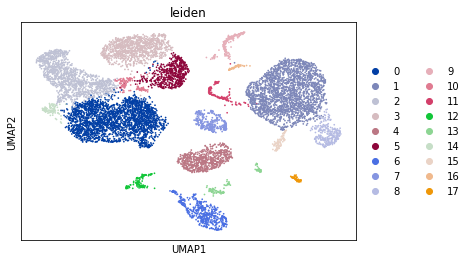

In [18]:
sc.pl.umap(adata, color="leiden")